# Transition Time Calculation

In this notebook we estimate the transition time from the quasipotential height. This is based on equation 237 of the Touchetter review paper [1].

[1] doi: 10.1016/j.physrep.2009.05.002

In [2]:
# Package Impoerts
import os
import pickle
import xarray as xr
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy.linalg as la


# MAM Code Imports
import sys
sys.path.append('/rds/general/user/cfn18/home/Instantons/L96-EBM-Instanton')
from fw_action import *
from mam_jax import *

## Loading Data

In [3]:
# MAM Results

c2s_mam = []
h2s_mam = []

# Cold to Saddle Instantons

wd = 'Data/varying-alpha/cold-to-saddle/'
files = os.listdir(wd)
files.sort()
for s in files:
    with open(wd + s, 'rb') as file:
        print(f'Opening {wd + s}')
        c2s_mam.append(pickle.load(file))
        

# Hot to Saddle Instantons
wd = 'Data/varying-alpha/hot-to-saddle/'
files = os.listdir(wd)
files.sort()
for s in files:
    with open(wd + s, 'rb') as file:
        print(f'Opening {wd + s}')
        h2s_mam.append(pickle.load(file))
        
# Heteroclinic Orbits

files = [f'../Deterministic-Model/Data/alpha{a}/cold-relaxation.nc' for a in ['0_0', '1_0']]

cold_relaxations = [xr.open_dataset(f) for f in files]

Opening Data/varying-alpha/cold-to-saddle/alpha_0_00.pickle
Opening Data/varying-alpha/cold-to-saddle/alpha_0_25.pickle
Opening Data/varying-alpha/cold-to-saddle/alpha_0_50.pickle
Opening Data/varying-alpha/cold-to-saddle/alpha_1_00.pickle
Opening Data/varying-alpha/hot-to-saddle/alpha_0_00.pickle
Opening Data/varying-alpha/hot-to-saddle/alpha_0_25.pickle
Opening Data/varying-alpha/hot-to-saddle/alpha_0_50.pickle
Opening Data/varying-alpha/hot-to-saddle/alpha_1_00.pickle


## Calculating Quasipotential height - Cold to Saddle Case

In [4]:
def path_lengths(x):
    return np.sqrt((x[:, 0] - x[0, 0])**2 + (x[:, 1] - x[0, 1])**2)

In [5]:
def grad_V(x):
    return jnp.array([x[0]*(x[0]**2 -1), 2 * x[1]])

In [9]:
R = np.array([[0, -1], [1, 0]]) # 90 degree rotation matrix

def drift(x, s):
    alpha, eps = s
    return - jnp.matmul((jnp.eye(2) + alpha * R), grad_V(x))

r = 1.
D = np.zeros((2, 2))
D[0, 0] = 1
D[1, 1] = r**2
Dinv = la.inv(D)

def diff_inv(x, s):
    return Dinv

alpha = mam_data['alpha']
eps = 10^-1

p = np.array([alpha, eps])

fw = FreidlinWentzell(drift, diff_inv)

In [35]:
# Choose data to load
k=-1
mam_data = c2s_mam[k]
relaxation_data = cold_relaxations[k]
print(relaxation_data.alpha)
print(mam_data['alpha'])

alpha = mam_data['alpha']
eps = 10**-1

p = np.array([alpha, eps])

# Unpack data
instanton_time = mam_data['time']
relaxation_time = relaxation_data.time.values
instanton = mam_data['instanton']
reverse_relaxation = np.flip(np.stack((relaxation_data.x.values, relaxation_data.y.values)).T, axis=0)

1.0
1.0


0.0
[0.  0.1]
0.25
[0.25 0.1 ]
0.5
[0.5 0.1]
1.0
[1.  0.1]


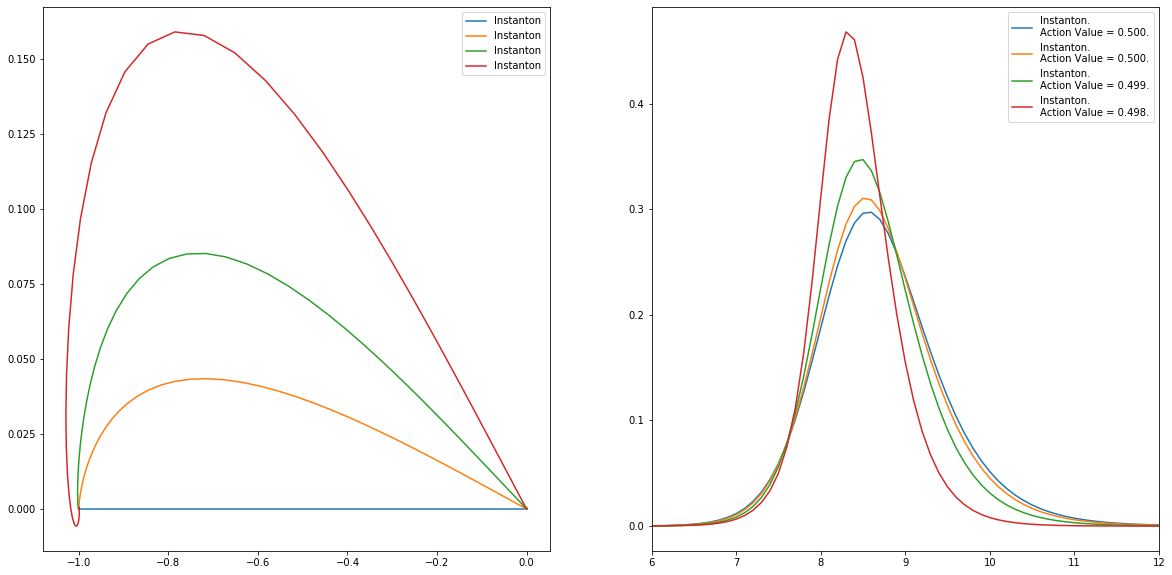

In [52]:
fig, axes = plt.subplots(ncols=2, figsize = (20, 10))

for k in range(4):
    
    mam_data = c2s_mam[k]
#     relaxation_data = cold_relaxations[k]
#     print(relaxation_data.alpha)
    print(mam_data['alpha'])

    alpha = mam_data['alpha']
    eps = 10**-1

    p = np.array([alpha, eps])

    # Unpack data
    instanton_time = mam_data['time']
    relaxation_time = relaxation_data.time.values
    instanton = mam_data['instanton']
    
    axes[0].plot(instanton[:, 0], instanton[:, 1], label='Instanton')
    # axes[0].plot(reverse_relaxation[:, 0], reverse_relaxation[:, 1], label='Relaxation Path')

    # Action Value Plot

    # Instanton
    print(p)
    av = fw.action(instanton, instanton_time, p)
    lbl = f'Instanton.\nAction Value = {av:.3f}.'
    axes[1].plot(instanton_time, 0.5 * fw.lagrangians(instanton, instanton_time, p), label = lbl)

# # Reverse Relaxation Path
# av = fw.action(reverse_relaxation, relaxation_time, p)
# lbl = f'Reverse Relaxation Path.\nAction Value = {av:.3f}.'
# axes[1].plot(path_lengths(reverse_relaxation), fw.lagrangians(reverse_relaxation, relaxation_time, p), label=lbl)
axes[1].legend()
axes[1].set_xlim((6, 12))
axes[0].legend()


ValueError: Unknown projection '3d'

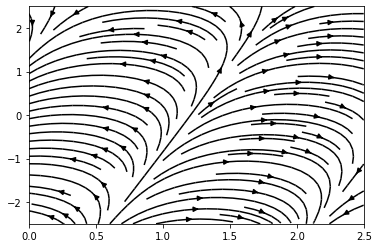

<Figure size 432x288 with 0 Axes>

In [14]:
fig_tmp, ax_tmp = plt.subplots()
x, y = np.mgrid[0:2.5:1000j, -2.5:2.5:1000j]
vx, vy = np.cos(x - y), np.sin(x - y)
res = ax_tmp.streamplot(x.T, y.T, vx, vy, color='k')
fig_tmp.show()
# extract the lines from the temporary figure
lines = res.lines.get_paths()
#for l in lines:
#    plot(l.vertices.T[0],l.vertices.T[1],'k')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for line in lines:
    old_x = line.vertices.T[0]
    old_y = line.vertices.T[1]
    # apply for 2d to 3d transformation here
    new_z = np.exp(-(old_x ** 2 + old_y ** 2) / 4)
    new_x = 1.2 * old_x
    new_y = 0.8 * old_y
    ax.plot(new_x, new_y, new_z, 'k')